# DSA Capstone - Milestone 2

Initial data acquisition, documentation, and start of data carpentry.   

[Public schools](#public)  
[Private schools](#private)  
[Childcare facilities](#childcare)  
[Sex offender registry](#msor)  
[St. Louis zoning](#zoning)  
[Zoning codes](#zoningcodes)  
[Buffers](#buffer)  

## To Do

**Start working with the data**  
✓ Reduce public school data to STL only  
✓ Reduce private school data to STL only  
✓ Initial carpentry for childcare facilities  
    - Reduce to STL only  
    - Convert address info to geocode-compatible format
    - Geocode addresses to get lat/lon  
☐ Examine childcare facility entries that failed geocoding  
    - Need key for other geocoder  
    ? Would it be better to manually fix these ~two dozen items?  
✓ Initial carpentry for sex offender registry
    - Reduce to STL only  
    - Convert address info to geocode-compatible format
    - Geocode addresses to get lat/lon
☐ Examine sex offender registry entries that failed geocoding  
✓ Merge zoning shapefile data with codes
    - Classify as residential/non-residential
    - Maintain original (translated) categorization

**Plot points on interactive map (folium)**  
✓ Plot public schools    
✓ Plot private schools  
✓ Plot childcare facilities  
✓ Plot sex offender locations

**Expand point data to reflect restricted area (circular buffer)**  
✓ Public schools - CRQ conversion/understanding  
✓ Public schools - expand to circle  
✓ Private schools - CRQ conversion/understanding  
✓ Private schools - expand to circle  
✓ Childcare facilities - CRQ conversion/understanding  
✓ Childcare facilities - expand to circle  

**Back up project to GitHub**  
✓ Set up a GitHub account  
✓ Figure out how to connect my Mizzou work to my GitHub repo  
✓ Commit/push my code & data to GitHub

**Load geodata into postgres/GIS database**  
https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.to_postgis.html   
☐ Public school geodata loaded  
☐ Private school geodata loaded  
☐ Childcare facility geodata loaded  
☐ Sex offender geodata loaded  
☐ Zoning data loaded

**Fuse geodata**  
☐ Subtract restricted areas from residential

**Cost data**  
☐ Find good source of price (rent and/or real estate purchase) data  
☐ Merge with zoning info

**Analyze results of geo work**  
☐ Quantify total residential area    
☐ Quantify total restricted area (ST_Union of all buffer zones)  
☐ Quantify residental area available to sex offenders (total res - total restricted)  
☐ Quantify potentially non-compliant sex offenders (w/in restricted area; filter/group by offense/level)  
☐ DO SOMETHING WITH COST INFO (TBD)


In [1]:
# IMPORTS
import geopandas as gpd
import pandas as pd

import os
import urllib.request
import requests
import shutil
from pathlib import Path
from zipfile import ZipFile

import matplotlib.pyplot as plt
from matplotlib import pyplot

import folium

from shapely.geometry import Point, Polygon

from geopandas.tools import overlay

from geopy.geocoders import Nominatim # for geocoding

<a id='public'></a>
### Locations of public schools in Missouri

Public school location data avaiable from the Missouri Spatial Data Information Service. There is no provided web link for downloading via code, so GeoJSON was manually downloaded and then uploaded to JupyterHub.

Location of downloadable data: 
https://data-msdis.opendata.arcgis.com/datasets/MSDIS::mo-public-schools/about
- Select "Download"
- Scroll down left frame until GeoJSON option appears
- Select "Download" under GeoJSON

In [18]:
# read in the public schools GeoJSON file
pub_schools = gpd.read_file('data/MO_Public_Schools.geojson')


In [19]:
# take a look the data
pub_schools.head()


FID CtyDist SchNum        SchID               Facility  \
0    1  019139   1050  019139-1050            Archie High   
1    2  024093   4060  024093-4060  Briarcliff Elementary   
2    3  029003   1050  029003-1050           Everton High   
3    4  029003   4020  029003-4020          Everton Elem.   
4    5  037039   3000  037039-3000         Hermann Middle   

                     Address Address2         City State        ZIP  ...  \
0        302 W State Route A                Archie    MO  647258217  ...   
1  4100 N.W. Briarcliff Road           Kansas City    MO  641161749  ...   
2             211 School St.               Everton    MO  656460107  ...   
3           509 E School St.               Everton    MO  656460107  ...   
4       164 Blue Pride Drive               Hermann    MO  650419802  ...   

  EGrade              Principal  PrinTitle Teachers Enrollment  \
0     12  Mrs. Michelle  Gaddie  Principal       31        282   
1     05  Mrs. Jonalee  Searcey  Principal       29        327   
2     12   Mrs. Jennifer Miller  Principal       13         84   
3     06   Mrs. Jennifer Miller  Principal       17         94   
4     08   Mr. Matthew  Mueller  Principal       28        305   

                            Email   Latitude  Longitude  Loc_Code  \
0        MGADDIE@ARCHIE.K12.MO.US  38.483911 -94.355873    MAP_MU   
1  jonalee.searcey@nkcschools.org  39.169199 -94.585375    MAP_MU   
2       jmiller@evertontigers.org  37.346417 -93.698996       MAP   
3       jmiller@evertontigers.org  37.346417 -93.698996       MAP   
4      mmueller@hermann.k12.mo.us  38.688745 -91.444722    MAP_MU   

                     geometry  
0  POINT (-94.35588 38.48392)  
1  POINT (-94.58538 39.16921)  
2  POINT (-93.69900 37.34642)  
3  POINT (-93.69824 37.34617)  
4  POINT (-91.44473 38.68875)  

[5 rows x 24 columns]

In [20]:
# examine datatypes within the dataset
print(pub_schools.geom_type.unique())
print(pub_schools.dtypes)


['Point']
FID              int64
CtyDist         object
SchNum          object
SchID           object
Facility        object
Address         object
Address2        object
City            object
State           object
ZIP             object
County          object
Phone           object
FAX             object
BGrade          object
EGrade          object
Principal       object
PrinTitle       object
Teachers         int64
Enrollment       int64
Email           object
Latitude       float64
Longitude      float64
Loc_Code        object
geometry      geometry
dtype: object


In [21]:
# drop the columns we have no use for 
pub_schools.drop(['CtyDist','SchNum','SchID','Phone','FAX','BGrade','EGrade','Principal','PrinTitle','Teachers','Enrollment','Email'], 
                 inplace=True, axis=1)
pub_schools.head()



FID               Facility                    Address Address2  \
0    1            Archie High        302 W State Route A            
1    2  Briarcliff Elementary  4100 N.W. Briarcliff Road            
2    3           Everton High             211 School St.            
3    4          Everton Elem.           509 E School St.            
4    5         Hermann Middle       164 Blue Pride Drive            

          City State        ZIP     County   Latitude  Longitude Loc_Code  \
0       Archie    MO  647258217       Cass  38.483911 -94.355873   MAP_MU   
1  Kansas City    MO  641161749       Clay  39.169199 -94.585375   MAP_MU   
2      Everton    MO  656460107       Dade  37.346417 -93.698996      MAP   
3      Everton    MO  656460107       Dade  37.346417 -93.698996      MAP   
4      Hermann    MO  650419802  Gasconade  38.688745 -91.444722   MAP_MU   

                     geometry  
0  POINT (-94.35588 38.48392)  
1  POINT (-94.58538 39.16921)  
2  POINT (-93.69900 37.34642)  
3  POINT (-93.69824 37.34617)  
4  POINT (-91.44473 38.68875)

Text(0.5, 1, 'Public Schools in Missouri')

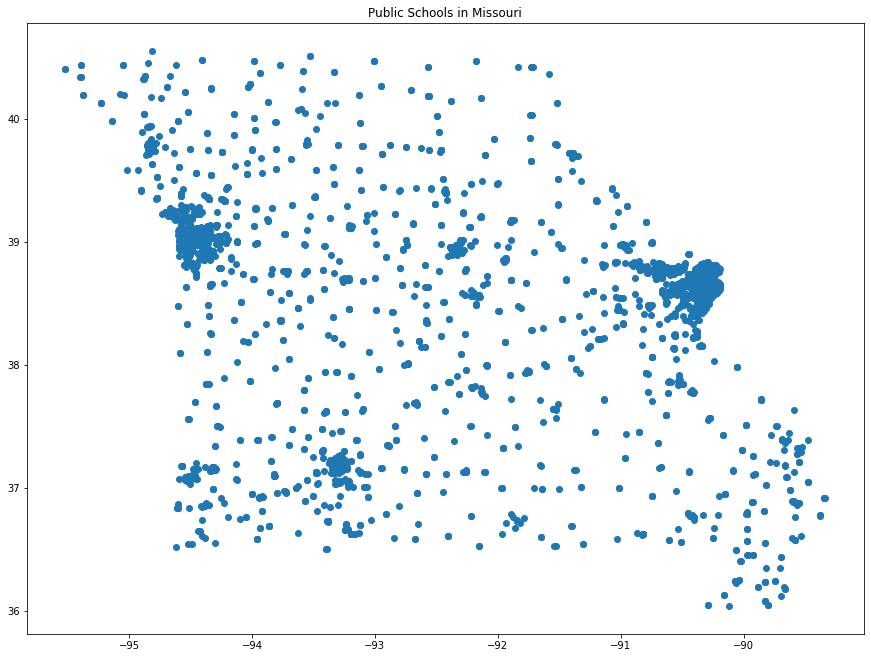

In [22]:
# visualize the data
%matplotlib inline
pub_schools.plot(figsize=(15,15))
plt.title("Public Schools in Missouri")


In [23]:
# this dataset covers the entire state, so filter it down to just St. Louis
# note that we may be able to expand to include the COUNTY of St. Louis - we can reassess this later
# sorted(pub_schools.City.unique())
stl_schools_pub = pub_schools.loc[pub_schools['City'] == 'St. Louis']


In [24]:
# plot with folium

# create a base map centered on St. Louis
map_stl_schools = folium.Map(
    location=[38.627003, -90.3],
    tiles='cartodbpositron',
    zoom_start=11,
)

# add a marker for each school
# label each facility with its name
for i in range(0,len(stl_schools_pub)):
   folium.Marker(
      location=[stl_schools_pub.iloc[i]['Latitude'], stl_schools_pub.iloc[i]['Longitude']],
      popup=stl_schools_pub.iloc[i]['Facility']
   ).add_to(map_stl_schools)

# display the map
map_stl_schools

<a id='private'></a>
### Locations of private schools in Missouri

Private school location data avaiable from the Missouri Spatial Data Information Service. There is no provided web link for downloading via code, so GeoJSON was manually downloaded and then uploaded to JupyterHub.

Location of downloadable data: 
https://data-msdis.opendata.arcgis.com/datasets/MSDIS::mo-2016-private-schools/about
- Select "Download"
- Scroll down left frame until GeoJSON option appears
- Select "Download" under GeoJSON

In [25]:
# read in the public schools GeoJSON file
pvt_schools = gpd.read_file('data/MO_2016_Private_Schools.geojson')


In [26]:
# take a look the data
pvt_schools.head()


FID    CODE                                           FACILITY  \
0    1          HILLCREST SEVENTH DAY ADVENTIST ELEMENTARY SCHOOL   
1    2  096402                            WESTWOOD JUNIOR ACADEMY   
2    3                                  MARANATHA BAPTIST ACADEMY   
3    4                                   WESTWOOD BAPTIST ACADEMY   
4    5                                   BEREAN CHRISTIAN ACADEMY   

            ADDRESS1          CITY STATE         ZIP     COUNTY       PHONE  \
0  9777 GRANDVIEW DR      OLIVETTE    MO  63132-2006  ST. LOUIS  3149931807   
1    16800 BAXTER RD  CHESTERFIELD    MO       63005  ST. LOUIS  6363362335   
2       200 ACORN DR    ST. ROBERT    MO       65584    PULASKI  5733365972   
3        419 CR 5231  POPLAR BLUFF    MO       63901     BUTLER  5737852922   
4    10385 US HWY 60        MONETT    MO       65708      BARRY  4172369008   

                           SCHEMAIL  ENROLLMENT GRADES   LATITUDE  LONGITUDE  \
0                                             0   K-08  38.678313 -90.393925   
1                                             0   K-08  38.660169 -90.582174   
2  MARANATHABAPTIST@CENTURYLINK.NET           0  PK-12  37.806866 -92.141096   
3                  OFFICE@WBAPB.COM           0  PK-12  36.799557 -90.444055   
4             AJORDAN@BCAMONETT.COM         105   K-12  36.910857 -93.876741   

  LOC_CODE                    geometry  
0      MAP  POINT (-90.39393 38.67831)  
1      MAP  POINT (-90.58218 38.66017)  
2      MAP  POINT (-92.14114 37.80686)  
3      MAP  POINT (-90.44407 36.79955)  
4      MAP  POINT (-93.87674 36.91086)

In [27]:
# examine datatypes within the dataset
print(pvt_schools.geom_type.unique())
print(pvt_schools.dtypes)


['Point']
FID              int64
CODE            object
FACILITY        object
ADDRESS1        object
CITY            object
STATE           object
ZIP             object
COUNTY          object
PHONE            int64
SCHEMAIL        object
ENROLLMENT       int64
GRADES          object
LATITUDE       float64
LONGITUDE      float64
LOC_CODE        object
geometry      geometry
dtype: object


In [28]:
# drop the columns we have no use for 
pvt_schools.drop(['CODE','PHONE','SCHEMAIL','ENROLLMENT','GRADES'], 
                 inplace=True, axis=1)
pvt_schools.head()



FID                                           FACILITY           ADDRESS1  \
0    1  HILLCREST SEVENTH DAY ADVENTIST ELEMENTARY SCHOOL  9777 GRANDVIEW DR   
1    2                            WESTWOOD JUNIOR ACADEMY    16800 BAXTER RD   
2    3                          MARANATHA BAPTIST ACADEMY       200 ACORN DR   
3    4                           WESTWOOD BAPTIST ACADEMY        419 CR 5231   
4    5                           BEREAN CHRISTIAN ACADEMY    10385 US HWY 60   

           CITY STATE         ZIP     COUNTY   LATITUDE  LONGITUDE LOC_CODE  \
0      OLIVETTE    MO  63132-2006  ST. LOUIS  38.678313 -90.393925      MAP   
1  CHESTERFIELD    MO       63005  ST. LOUIS  38.660169 -90.582174      MAP   
2    ST. ROBERT    MO       65584    PULASKI  37.806866 -92.141096      MAP   
3  POPLAR BLUFF    MO       63901     BUTLER  36.799557 -90.444055      MAP   
4        MONETT    MO       65708      BARRY  36.910857 -93.876741      MAP   

                     geometry  
0  POINT (-90.39393 38.67831)  
1  POINT (-90.58218 38.66017)  
2  POINT (-92.14114 37.80686)  
3  POINT (-90.44407 36.79955)  
4  POINT (-93.87674 36.91086)

Text(0.5, 1, 'Private Schools in Missouri')

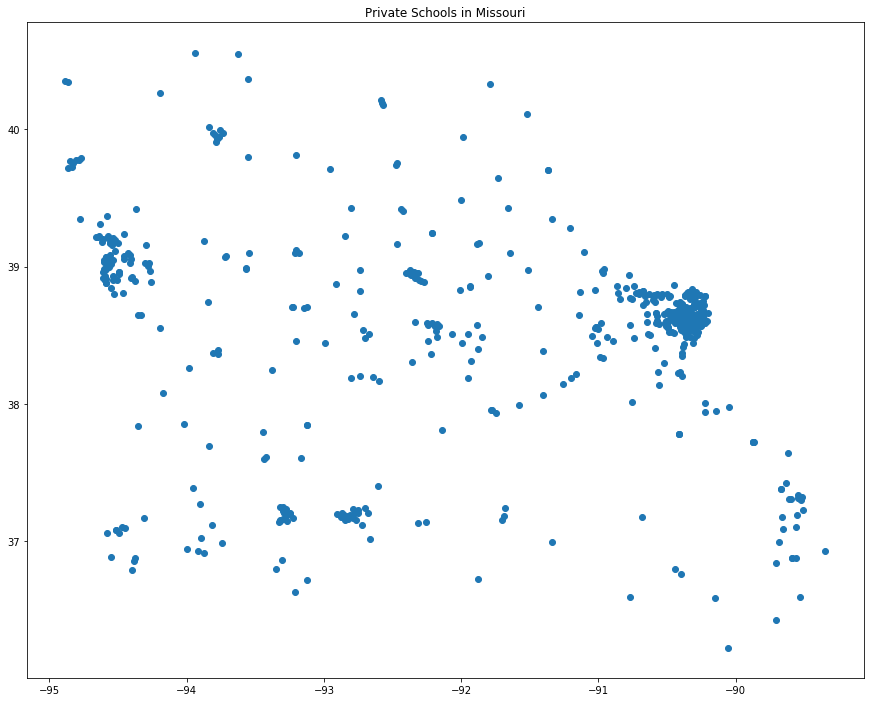

In [29]:
# visualize the data
%matplotlib inline
pvt_schools.plot(figsize=(15,15))
plt.title("Private Schools in Missouri")


In [30]:
# this dataset covers the entire state, so filter it down to just St. Louis
# note that we may be able to expand to include the COUNTY of St. Louis - we can reassess this later
# sorted(pvt_schools.CITY.unique())
stl_schools_pvt = pvt_schools.loc[pvt_schools['CITY'] == 'ST. LOUIS']


In [35]:
# plot with folium

# create a base map centered on St. Louis
map_stl_schools_pvt = folium.Map(
    location=[38.627003, -90.3],
    tiles='cartodbpositron',
    zoom_start=11,
)

# add a marker for each school
# label each facility with its name
for i in range(0,len(stl_schools_pvt)):
   folium.Marker(
      location=[stl_schools_pvt.iloc[i]['LATITUDE'], stl_schools_pvt.iloc[i]['LONGITUDE']],
      popup=stl_schools_pvt.iloc[i]['FACILITY']
   ).add_to(map_stl_schools_pvt)

# display the map
map_stl_schools_pvt

<a id='childcare'></a>
### Childcare facilities in Missouri

List of all licensed and license-exempt childcare providers in Missouri. Basic information in table form including county, facility type, facility name, street address, city, state, and zip code. Provided by Missouri Dept of Elementary and Secondary Education (DESE), Child Care Compliance team.

https://dese.mo.gov/childhood/child-care/find-care  
https://dese.mo.gov/media/70106/download  
https://healthapps.dhss.mo.gov/childcaresearch/



In [36]:
file_url = "https://dese.mo.gov/media/70106/download"

# Designate the local filename
local_file_name = 'regulated-child-care-facilities.xlsx'

# Designate the local file name with a path to a temp directory.
file_Path = Path('data/')  
file_Path /= local_file_name

resp = requests.get(file_url)
with open(file_Path, 'wb') as output:
    output.write(resp.content)

In [37]:
# read in the childcare facility data we just unzipped
childcare = pd.read_excel(file_Path)


In [38]:
# take a look the data
childcare.head()


COUNTY           facility type regulatory status  \
0  BOLLINGER       CHILD CARE CENTER        LICENSABLE   
1  BOLLINGER             FAMILY HOME        LICENSABLE   
2  BOLLINGER             FAMILY HOME        LICENSABLE   
3  BOLLINGER              GROUP HOME        LICENSABLE   
4  BOLLINGER  LICENSE EXEMPT PROGRAM    LICENSE EXEMPT   

                                   facility name      dvn  \
0              EAST MISSOURI ACTION AGENCY, INC.   705919   
1                           HOLLY HOESLI DAYCARE  2300674   
2                          HOTOP, RANDA SHARLEAN  1063085   
3                                  SITZ, MARLA L   384016   
4  FIRST BAPTIST CHURCH CHILD DEVELOPMENT CENTER  1145406   

              street address         city state    zip code facility phone  \
0  400 STATE HIGHWAY 34 EAST  MARBLE HILL    MO       63764   573 238 3652   
1            16424 AZALEA LN      LEOPOLD    MO  63760-9614   573 238 5452   
2      40072 STATE HIGHWAY K   PERRYVILLE    MO  63775-7779   573 788 2352   
3          10310 HERITAGE LN        ZALMA    MO  63787-8726   573 722 3009   
4            502 BROADWAY ST  MARBLE HILL    MO       63764   573 238 2545   

   ... Column16349 Column16350 Column16351 Column16352 Column16353  \
0  ...         NaN         NaN         NaN         NaN         NaN   
1  ...         NaN         NaN         NaN         NaN         NaN   
2  ...         NaN         NaN         NaN         NaN         NaN   
3  ...         NaN         NaN         NaN         NaN         NaN   
4  ...         NaN         NaN         NaN         NaN         NaN   

  Column16354 Column16355 Column16356 Column16357 Column16358  
0         NaN         NaN         NaN         NaN         NaN  
1         NaN         NaN         NaN         NaN         NaN  
2         NaN         NaN         NaN         NaN         NaN  
3         NaN         NaN         NaN         NaN         NaN  
4         NaN         NaN         NaN         NaN         NaN  

[5 rows x 16384 columns]

In [39]:
# there are a lot of columns! look at names to inform our downselect
childcare.columns.values.tolist()


['COUNTY',
 'facility type',
 'regulatory status',
 'facility name',
 'dvn',
 'street address',
 'city',
 'state',
 'zip code',
 'facility phone',
 'director/provider',
 'effective date',
 'Anniversary/Expiration Date',
 'status',
 'from hours',
 'to hours',
 'Days of Operation',
 'Months of Operation',
 'minimum age',
 'maximum age',
 'total capacity',
 'owner name',
 'mailing street address',
 'mailing city',
 'mailing state',
 'mailing zip code',
 'Column1',
 'Column2',
 'Column3',
 'Column4',
 'Column5',
 'Column6',
 'Column7',
 'Column8',
 'Column9',
 'Column10',
 'Column11',
 'Column12',
 'Column13',
 'Column14',
 'Column15',
 'Column16',
 'Column17',
 'Column18',
 'Column19',
 'Column20',
 'Column21',
 'Column22',
 'Column23',
 'Column24',
 'Column25',
 'Column26',
 'Column27',
 'Column28',
 'Column29',
 'Column30',
 'Column31',
 'Column32',
 'Column33',
 'Column34',
 'Column35',
 'Column36',
 'Column37',
 'Column38',
 'Column39',
 'Column40',
 'Column41',
 'Column42',
 'Column4

In [40]:
# clean and covert the data

# reduce the childcare dataframe to only the columns we will need
childcare = childcare.loc[:,'COUNTY':'zip code']

# replace spaces in column names with '_' to make life easier
childcare.columns = childcare.columns.str.replace(' ', '_')

# this dataset covers the entire state, so filter it down to just St. Louis
# note that we may be able to expand to include the COUNTY of St. Louis - we can reassess this later
# sorted(childcare.city.unique())
childcare = childcare.loc[childcare['city'] == 'ST LOUIS']

# merge together street addres, city, and state to create the "full address"
childcare['full_address'] = childcare.street_address + "," + childcare.city + "," + childcare.state


In [ ]:
# set up the geocoder
geolocator = Nominatim(timeout=10, user_agent = "myGeolocator")


#### Test out the geocoder with a couple of basic, manual addresses

In [41]:
# need to convert text addresses to lat/lon (geocoding)
location = geolocator.geocode('4550 Kester Mill Rd,Winston-Salem,NC')
print(location)
print((location.latitude, location.longitude))


Walmart Supercenter, 4550, Kester Mill Road, Winston-Salem, Forsyth County, North Carolina, 27103, United States
(36.06752315, -80.3372069310351)


In [42]:
location = geolocator.geocode('16 Spencers Xing,Saint Peters,MO')
print(location)
print((location.latitude, location.longitude))

16, Spencers Crossing, Spencer Creek South, Saint Peters, Saint Charles County, Missouri, 63376, United States
(38.77808885, -90.59041425345099)


#### Put together the childcare list + geocoder to get lat/lon that we can plot.
First, we'll have to make a single "full address" column that can be passed to the geocoder. Then, we can add a new column to the dataframe that includes lat/lon.

In [43]:
# pass the full addresses to the geocoder and store the results in a new column
childcare['geocode'] = childcare.full_address.apply(geolocator.geocode)


In [44]:
# remove rows that do not have location data
childcare_nona = childcare.dropna().copy()


#### Troubleshoot the entries that failed geocoding
Examine 'None' values in 'geocode' column and attempt to resolve.  
[Troubleshooting can be found in this notebook](https://glap.dsa.missouri.edu/user/psm2207/notebooks/DSA_Capstone/Failed_Geocoding.ipynb)

In [111]:
# how many entries didn't translate into lat/lon values?
print(len(childcare.index)-len(childcare_nona.index),'of',len(childcare.index),'entries failed geocoding')

26 of 448 entries failed geocoding


In [109]:
# get the latitude and longitude values from the geodata column and put them in their own columns for easier plotting
childcare_nona['lat'] = [g.latitude for g in childcare_nona.geocode]
childcare_nona['long'] = [g.longitude for g in childcare_nona.geocode]


In [110]:
# create a base map centered on St. Louis
map_childcare = folium.Map(
    location=[38.627003, -90.3],
    tiles='cartodbpositron',
    zoom_start=11,
)

# add a marker for each childcare facility
# label each facility with its name
for i in range(0,len(childcare_nona)):
   folium.Marker(
      location=[childcare_nona.iloc[i]['lat'], childcare_nona.iloc[i]['long']],
      popup=childcare_nona.iloc[i]['facility_name']
   ).add_to(map_childcare)

# display the map
map_childcare

<a id='msor'></a>
### Missouri sex offender registry

Missouri sex offender registry. Basic information in table form including name, address, city, state, zip code, and county. Provided by Missouri State Highway Patrol. Updated January 2022. 

https://www.mshp.dps.missouri.gov/MSHPWeb/PatrolDivisions/CRID/SOR/msor.zip  
https://www.mshp.dps.missouri.gov/CJ38/disclaimer.jsp


In [14]:
# Designate the URL for a file we want;
file_URL = 'https://www.mshp.dps.missouri.gov/MSHPWeb/PatrolDivisions/CRID/SOR/msor.zip'

# Designate the local filename
local_file_name = 'msor.zip'

# Designate the local file name with a path to a temp directory.
file_Path = Path('data/')  
file_Path /= local_file_name

# Download the file from `file_url` and save it locally under `file_name`:
with urllib.request.urlopen(file_URL) as response,  file_Path.open(mode='w+b') as out_file:
    shutil.copyfileobj(response, out_file)
    
# unzip file
to_unzip = ZipFile('data/msor.zip', 'r')
unzipped = 'data/msor/'
to_unzip.extractall(unzipped)
to_unzip.close()


In [15]:
# read in the sex offender data we just unzipped
msor = pd.read_excel('data/msor/msor.xlsx')


In [16]:
# take a look the data
msor.head(20)


MISSOURI STATE HIGHWAY PATROL       Unnamed: 1  \
0                 Entire Sex Offender Registry Report              NaN   
1                                                                  NaN   
2                                                                  NaN   
3                             REPORT DATE: 01/27/2022              NaN   
4                              REPORT TIME: 04.00.02               NaN   
5                                                                  NaN   
6   ACTIVE OFFENDERS FOUND:-----------------------...              NaN   
7   INCARCERATED OFFENDERS FOUND:-----------------...              NaN   
8   MOVED OUT OF STATE (PAST YEAR ONLY) OFFENDERS ...              NaN   
9   PENDING REGISTRATION OFFENDERS FOUND:---------...              NaN   
10  TOTAL OFFENDERS FOUND:------------------------...              NaN   
11                                                                 NaN   
12                                               Name          Address   
13                                     ABBOTT, CARL D          UNKNOWN   
14                                  ABBOTT, MICHAEL W   6911 WILLIS DR   
15                                   ABBOTT, RODNEY L    905 E MAIN ST   
16                                   ABBOTT, STEVEN R    1621 N 1ST ST   
17                                   ABBOTT, STEVEN R    1621 N 1ST ST   
18                                   ABBOTT, STEVEN R    1621 N 1ST ST   
19                                 ABBOTT, TALMADGE A  604 E SPRING ST   

         Unnamed: 2 Unnamed: 3 Unnamed: 4     Unnamed: 5  \
0               NaN        NaN        NaN            NaN   
1               NaN        NaN        NaN            NaN   
2               NaN        NaN        NaN            NaN   
3               NaN        NaN        NaN            NaN   
4               NaN        NaN        NaN            NaN   
5               NaN        NaN        NaN            NaN   
6               NaN        NaN        NaN            NaN   
7               NaN        NaN        NaN            NaN   
8               NaN        NaN        NaN            NaN   
9               NaN        NaN        NaN            NaN   
10              NaN        NaN        NaN            NaN   
11              NaN        NaN        NaN            NaN   
12             City         St        Zip         County   
13          UNKNOWN         MO      00000            NaN   
14  PLEASANT VALLEY         MO      64068           CLAY   
15           CABOOL         MO      65689          TEXAS   
16      SAINT LOUIS         MO      63102  ST LOUIS CITY   
17      SAINT LOUIS         MO      63102  ST LOUIS CITY   
18      SAINT LOUIS         MO      63102  ST LOUIS CITY   
19         DONIPHAN         MO      63935         RIPLEY   

                         Unnamed: 6 Unnamed: 7 Unnamed: 8 Unnamed: 9  \
0                               NaN        NaN        NaN        NaN   
1                               NaN        NaN        NaN        NaN   
2                               NaN        NaN        NaN        NaN   
3                               NaN        NaN        NaN        NaN   
4                               NaN        NaN        NaN        NaN   
5                               NaN        NaN        NaN        NaN   
6                               NaN        NaN        NaN        NaN   
7                               NaN        NaN        NaN        NaN   
8                               NaN        NaN        NaN        NaN   
9                               NaN        NaN        NaN        NaN   
10                              NaN        NaN        NaN        NaN   
11                              NaN        NaN        NaN        NaN   
12                          Offense      Count  Compliant       Tier   
13           ENDANGER WELFARE CHILD          2          A          3   
14         PROM CHILD PORNO 2ND DEG          1          Y          2   
15  STAT SODOMY-1ST DEG-PERS UND 14          2          

It looks like there's a lot of explanatory information in the first few rows of the file. Our actual data starts at row 13, so let's adjust the read accordingly.

In [17]:
# read in the sex offender data again, but this time start with the actual header row
msor = pd.read_excel('data/msor/msor.xlsx', header=13)
msor.head()


Name         Address             City  St      Zip  \
0     ABBOTT, CARL D         UNKNOWN          UNKNOWN  MO      0.0   
1  ABBOTT, MICHAEL W  6911 WILLIS DR  PLEASANT VALLEY  MO  64068.0   
2   ABBOTT, RODNEY L   905 E MAIN ST           CABOOL  MO  65689.0   
3   ABBOTT, STEVEN R   1621 N 1ST ST      SAINT LOUIS  MO  63102.0   
4   ABBOTT, STEVEN R   1621 N 1ST ST      SAINT LOUIS  MO  63102.0   

          County                          Offense  Count Compliant  Tier  \
0            NaN           ENDANGER WELFARE CHILD      2         A     3   
1           CLAY         PROM CHILD PORNO 2ND DEG      1         Y     2   
2          TEXAS  STAT SODOMY-1ST DEG-PERS UND 14      2         Y     3   
3  ST LOUIS CITY          CHILD MOLEST-1ST DEGREE      1         Y     3   
4  ST LOUIS CITY            SEXUAL MISCONDUCT-1ST      1         Y     3   

  Date of Birth  
0    1976-10-14  
1    1982-11-11  
2    1972-05-07  
3    1982-08-29  
4    1982-08-29

In [197]:
# replace spaces in column names with '_' to make life easier
msor.columns = msor.columns.str.replace(' ', '_')

# filter dataset down to just St. Louis
# msor.City.unique().tolist()
msor = msor.loc[msor['City'].isin(['SAINT LOUIS','ST LOUIS','ST  LOUIS'])]

# convert zipcode from float to int
# msor.Zip.unique().tolist()
msor['Zip'] = msor['Zip'].astype(int)

# merge together street addres, city, and state to create the "full address"
msor['full_address'] = msor.Address + "," + msor.City + "," + msor.St


In [229]:
msor.head()


Name                   Address         City  St    Zip  \
3       ABBOTT, STEVEN R             1621 N 1ST ST  SAINT LOUIS  MO  63102   
4       ABBOTT, STEVEN R             1621 N 1ST ST  SAINT LOUIS  MO  63102   
5       ABBOTT, STEVEN R             1621 N 1ST ST  SAINT LOUIS  MO  63102   
10       ABDI, IBRAHIM A    3764 CHIPPEWA ST APT 8  SAINT LOUIS  MO  63116   
18  ABERNATHY, RANDELL L  3866 S SPRING AVE APT 1S  SAINT LOUIS  MO  63116   

           County                          Offense  Count Compliant  Tier  \
3   ST LOUIS CITY          CHILD MOLEST-1ST DEGREE      1         Y     3   
4   ST LOUIS CITY            SEXUAL MISCONDUCT-1ST      1         Y     3   
5   ST LOUIS CITY  STAT SODOMY-1ST DEG-PERS UND 14      1         Y     3   
10  ST LOUIS CITY            SEXUAL MISCONDUCT-3RD      1         Y     1   
18  ST LOUIS CITY             AGG CRIM SEX ASSAULT      2         Y     3   

   Date_of_Birth                             full_address  \
3     1982-08-29             1621 N 1ST ST,SAINT LOUIS,MO   
4     1982-08-29             1621 N 1ST ST,SAINT LOUIS,MO   
5     1982-08-29             1621 N 1ST ST,SAINT LOUIS,MO   
10    1981-09-08    3764 CHIPPEWA ST APT 8,SAINT LOUIS,MO   
18    1969-07-30  3866 S SPRING AVE APT 1S,SAINT LOUIS,MO   

                                              geocode  
3   (1621, North 1st Street, Near North Riverfront...  
4   (1621, North 1st Street, Near North Riverfront...  
5   (1621, North 1st Street, Near North Riverfront...  
10                                               None  
18                                               None

In [228]:
# pass the full addresses to the geocoder and store the results in a new column
msor['geocode'] = msor.full_address.apply(geolocator.geocode)


In [230]:
# remove rows that do not have location data
msor_nona = msor.dropna().copy()


In [231]:
# get the latitude and longitude values from the geodata column and put them in their own columns for easier plotting
msor_nona['lat'] = [g.latitude for g in msor_nona.geocode]
msor_nona['long'] = [g.longitude for g in msor_nona.geocode]


In [233]:
# create a base map centered on St. Louis
map_sexoffenders = folium.Map(
    location=[38.627003, -90.3],
    tiles='cartodbpositron',
    zoom_start=11,
)

# add a marker for each childcare facility
# label each facility with its name
for i in range(0,len(msor_nona)):
   folium.Marker(
      location=[msor_nona.iloc[i]['lat'], msor_nona.iloc[i]['long']],
      popup=msor_nona.iloc[i]['Offense']
   ).add_to(map_sexoffenders)

# display the map
map_sexoffenders

<a id='zoning'></a>
### St. Louis zoning  

Shapefiles of parcel zoning and multi-zoned parcels. Provided by City of St. Louis Department of Planning and Urban Design. Direct download of data in a ZIP file: https://www.stlouis-mo.gov/data/upload/data-files/zoning.zip 

- Download the ZIP file to local Jupyter directory
- Unzip the file
- Load the newly-unzipped data

In [18]:
# Designate the URL for a file we want;
file_URL = 'https://www.stlouis-mo.gov/data/upload/data-files/zoning.zip'

# Designate the local filename
local_file_name = 'zoning.zip'

# Designate the local file name with a path to a temp directory.
file_Path = Path('data/')  
file_Path /= local_file_name

# Download the file from `file_url` and save it locally under `file_name`:
with urllib.request.urlopen(file_URL) as response,  file_Path.open(mode='w+b') as out_file:
    shutil.copyfileobj(response, out_file)
    
# unzip file
to_unzip = ZipFile('data/zoning.zip', 'r')
unzipped = 'data/zoning/'
to_unzip.extractall(unzipped)
to_unzip.close()
for file in os.listdir(unzipped):
    if file.endswith(".shp"):
        shape_file =  unzipped + '/' + file  
        

In [11]:
# read in the zoning data we just unzipped
zoning = gpd.read_file('data/zoning')


In [12]:
# take a look the data
zoning.head()


HANDLE LAYER                                           geometry
0  10001000005     X  POLYGON ((589486.009 1014246.047, 589479.385 1...
1  10001000010     X  MULTIPOLYGON (((589502.983 1014298.717, 589502...
2  10001000020     X  POLYGON ((589543.160 1014489.573, 589530.804 1...
3  10001000032     L  POLYGON ((589616.605 1014189.680, 589610.386 1...
4  10001000034     X  POLYGON ((589596.043 1014198.555, 589595.202 1...

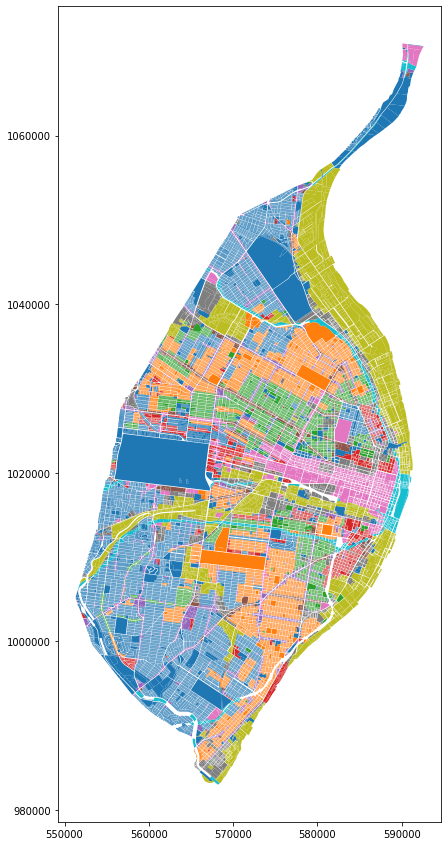

In [6]:
# visualize the data
zoning.plot(figsize=(15,15), column='LAYER')


In [7]:
# examine the zoning codes in use 
# we will need to classify these as "residential" vs. "non-residential"
codes = zoning['LAYER'].unique()
codes.sort()
codes


array(['2', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L',
       'X'], dtype=object)

<a id='zoningcodes'></a>
## Zoning codes

Looking at the output of `zoning.head()` above, we see that the zoning codes (stored in the 'layer' column) are not easily interpretable. Thus, we need the "decoder ring" that translates these codes into categories we may later group into “residential” or “non-residential” bins.

The sources for this data contains various Microsoft Access databases of codes, descriptions, and child tables used in the zoning tables. Provided by City of St. Louis Department of Planning and Urban Design.

Location of downloadable data: https://www.stlouis-mo.gov/data/datasets/distribution.cfm?id=61 
- Select "Download Codes Access Database"
- Unzip 'codes.zip'
- Within the unzipped 'codes' directory, unzip 'PrclCode.zip'
- Open the unzipped 'PrclCode' directory 
- Open the 'PrclCode' Access database
- Select the 'CdZoning' table and export as CSV

In [22]:
# read in the CSV file of zoning codes and examine its contents
zoning_code_translation = pd.read_csv('data/CdZoning.csv')
zoning_code_translation


ZoningCode                        Descr
0           A    Single Family Residential
1           B       Two Family Residential
2           C  Multiple Family Residential
3           D  Multiple Family Residential
4           E  Multiple Family Residential
5           F      Neighborhood Commercial
6           G  Local Commercial and Office
7           H              Area Commercial
8           I    Central Business District
9           J                   Industrial
10          K                 Unrestricted
11          L  Jefferson Memorial District
12          X                    Not Zoned

In [8]:
# There's a code in our dataframe (LAYER == 2) that is not in the table of zoning codes
# Find out what's up with that

zoning.loc[zoning['LAYER'] == '2']


HANDLE LAYER                                           geometry
1046    10337000010     2  POLYGON ((587663.072 1026798.694, 587674.020 1...
1327    10382000220     2  POLYGON ((585123.555 1011178.725, 585064.628 1...
1423    10387050010     2  POLYGON ((584985.960 1011783.889, 585121.951 1...
1434    10387060070     2  POLYGON ((584941.284 1011532.758, 584869.475 1...
1531    10396000092     2  POLYGON ((583731.212 1010902.660, 583687.601 1...
...             ...   ...                                                ...
127256  19111000020     2  POLYGON ((577569.057 1051036.771, 577359.799 1...
127257  19111000030     2  POLYGON ((578030.773 1051307.393, 577569.057 1...
127290  19115000085     2  POLYGON ((579054.763 1054356.315, 578887.909 1...
127303  19115000270     2  POLYGON ((579032.220 1053988.243, 578935.282 1...
127319  19116000060     2  POLYGON ((580451.442 1055795.097, 580445.668 1...

[448 rows x 3 columns]

In [13]:
# Okay, there are a lot of these. Visualize on easily-identified map tiles to get a better idea of what they are.

m = folium.Map([38.6529545, -90.2411166], tiles='openstreetmap', zoom_start=13)

# apply the outlines to the map
folium.GeoJson(zoning.loc[zoning['LAYER'] == '2']).add_to(m)

# display map
m


In [22]:
# Add a column that translates the zoning values in the geodf to either "Residential" (TRUE) or "Non-Res" (FALSE)
# first, copy the "LAYER" info into a new column
zoning['RES'] = zoning['LAYER'] 
# next, convert the residential codes to "True" and the non-residential codes to "False"
zoning['RES'] = zoning['RES'].replace(['A','B','C','D','E','K'],True)
zoning['RES'] = zoning['RES'].replace(['F','G','H','I','J','L','X','2'],False)
                                   

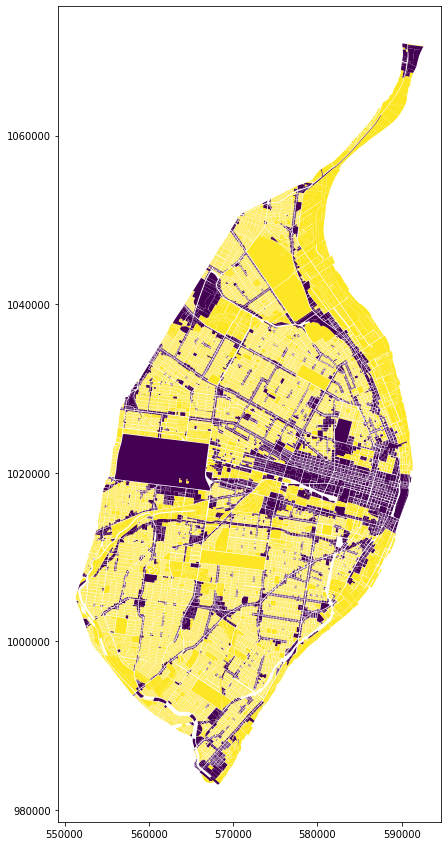

In [30]:
# visualize the updated zoning data
zoning.plot(figsize=(15,15), column='RES')


<a id='buffer'></a>
## Add buffers to point data

Now that we have ingested the source data for public schools, private schools, and childcare facilities, we can create the buffer (residency restriction) zones around these points. Here is the buffer information from the [Missouri Sex Offender Registry Fact Sheet](https://www.mshp.dps.missouri.gov/MSHPWeb/PatrolDivisions/CRID/SOR/factsheet.html#specialConsiderations):
 >Certain sexual offenders may not reside within 1,000 feet of any public or private school up to the 12th grade or childcare facility which is in existence at the time of the offender establishing his or her residency.

#### Buffers for public schools

In [61]:
# first, we need to understand the CRS for our data
print('Starting CRS:',stl_schools_pub.crs)

# reproject to local CRS with units in feet or meters
# https://epsg.io/6512 is expressed in meters
stl_schools_pub = stl_schools_pub.to_crs(6512)

print('New CRS:',stl_schools_pub.crs)


Starting CRS: {'init': 'epsg:4326'}
New CRS: 6512


In [62]:
# expand points to circles with radius = 1000 ft (the min residential distance for a registered sex offender)
mindist_ft = 1000
stl_schools_pub['geometry'] = stl_schools_pub.buffer(mindist_ft*0.3048) # convert feet to meters by multiplying by 0.3048


#### Buffers for private schools

In [65]:
# first, we need to understand the CRS for our data
print('Starting CRS:',stl_schools_pvt.crs)

# reproject to local CRS with units in feet or meters
# https://epsg.io/6512 is expressed in meters
stl_schools_pvt = stl_schools_pvt.to_crs(6512)

print('New CRS:',stl_schools_pvt.crs)


Starting CRS: {'init': 'epsg:4326'}
New CRS: 6512


In [66]:
# expand points to circles with radius = 1000 ft (the min residential distance for a registered sex offender)
# use the same 'mindist_ft' variable/value tat we used before
stl_schools_pvt['geometry'] = stl_schools_pvt.buffer(mindist_ft*0.3048) # convert feet to meters by multiplying by 0.3048


#### Buffers for childcare facilities

In [246]:
# unlike the public and private school data, the childcare facility data didn't come from a shapefile
# we need to turn what we have into a geodataframe 

# create the 'geometry' column for the geodataframe
geometry = [Point(xy) for xy in zip(childcare_nona['long'], childcare_nona['lat'])]
# generate the geodataframe using the childcare df + the geometry info
# set the CRS (in degrees) as part of this process
childcare_gdf = gpd.GeoDataFrame(childcare_nona, geometry = geometry, crs=4326) 


In [247]:
# understand the basic CRS that we already set
print('Starting CRS:',childcare_gdf.crs)

# reproject to local CRS with units in feet or meters
# https://epsg.io/6512 is expressed in meters
childcare_gdf = childcare_gdf.to_crs(6512)

print('New CRS:',childcare_gdf.crs)

Starting CRS: 4326
New CRS: 6512


In [248]:
# expand points to circles with radius = 1000 ft (the min residential distance for a registered sex offender)
# use the same 'mindist_ft' variable/value tat we used before
childcare_gdf['geometry'] = childcare_gdf.buffer(mindist_ft*0.3048) # convert feet to meters by multiplying by 0.3048


#### Plot buffers together

In [249]:
# visualize the schools (with 1000ft buffers) on Open Street tiles
map_buffer_zones = folium.Map([38.6529545, -90.2411166], tiles='openstreetmap', zoom_start=13)

# apply the CHILDCARE FACILITY zones to the map
folium.GeoJson(childcare_gdf['geometry'], style_function=lambda feature: {
        'fillColor': '#db3e00', 'color': '#db3e00'}).add_to(map_buffer_zones)

# apply the PUBLIC school zones to the map
folium.GeoJson(stl_schools_pub, style_function=lambda feature: {
        'fillColor': '#2196F3', 'color': '#2196F3'}).add_to(map_buffer_zones)

# apply the PRIVATE school zones to the map
folium.GeoJson(stl_schools_pvt, style_function=lambda feature: {
        'fillColor': '#003dff', 'color': '#003dff'}).add_to(map_buffer_zones)

# display map
map_buffer_zones

***

# Summary

We now have the data needed to conduct our analysis:
1. Locations of public schools in Missouri
    - This data will need to be filtered down to St. Louis only
2. Locations of private schools in Missouri
    - This data will need to be filtered down to St. Louis only
3. List of childcare facilities in Missouri (with addresses)
    - This data will need to be filtered down to St. Louis only
    - Addresses will likely need to be converted to lat/lon for plotting
4. Missouri sex offender registry (with addresses)
    - This data will need to be filtered down to St. Louis only
    - Addresses will likely need to be converted to lat/lon for plotting
5. St. Louis parcel zoning geodata
6. Descriptions of St. Louis parcel zoning codes